In [1]:
import sys
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.utils import load_config, load_ground_truth

CONFIG_PATH = PROJECT_ROOT / "configs" / "settings.yaml"
cfg = load_config(CONFIG_PATH)
gt_dict = load_ground_truth(cfg.gt_path)

def load_distance_signal(video_id: str) -> np.ndarray:
    path = cfg.results_dir / f"{video_id}_distance.npy"
    return np.load(path)

def load_predictions(video_id: str) -> List[int]:
    path = cfg.results_dir / f"{video_id}_boundaries.txt"
    if not path.exists():
        return []
    tokens = path.read_text(encoding="utf-8").split()
    values = []
    for token in tokens[1:]:
        try:
            values.append(int(token))
        except ValueError:
            continue
    return sorted(set(values))

def moving_average(signal: np.ndarray, kernel: int = 5) -> np.ndarray:
    if signal.size == 0 or kernel <= 1:
        return signal
    kernel = min(kernel, signal.size)
    window = np.ones(kernel, dtype=np.float32) / float(kernel)
    return np.convolve(signal, window, mode="same")

def plot_video(video_id: str, smooth_kernel: int = 5) -> None:
    signal = load_distance_signal(video_id)
    frames = np.arange(signal.size) * cfg.stride + cfg.window
    smooth = moving_average(signal, kernel=smooth_kernel)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(frames, signal, label="distance", alpha=0.35)
    ax.plot(frames, smooth, label=f"moving_avg({smooth_kernel})", linewidth=2.0)

    gt_frames = gt_dict.get(video_id, [])
    for idx, frame in enumerate(gt_frames):
        ax.axvline(frame, color="tab:green", linestyle="--", alpha=0.6,
                   label="GT" if idx == 0 else None)

    pred_frames = load_predictions(video_id)
    for idx, frame in enumerate(pred_frames):
        ax.axvline(frame, color="tab:red", linestyle="-", alpha=0.6,
                   label="Pred" if idx == 0 else None)

    ax.set_title(f"Distance Signal and Boundaries - {video_id}")
    ax.set_xlabel("Frame (i*stride + window)")
    ax.set_ylabel("Distance")
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.2)

    output_path = cfg.results_dir / "plots" / f"{video_id}.png"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=150, bbox_inches="tight")
    plt.show()


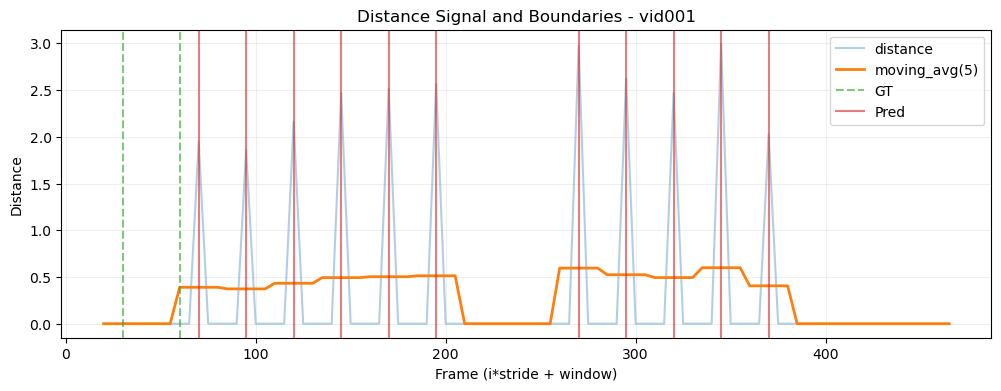

In [2]:
plot_video("vid001", smooth_kernel=5)

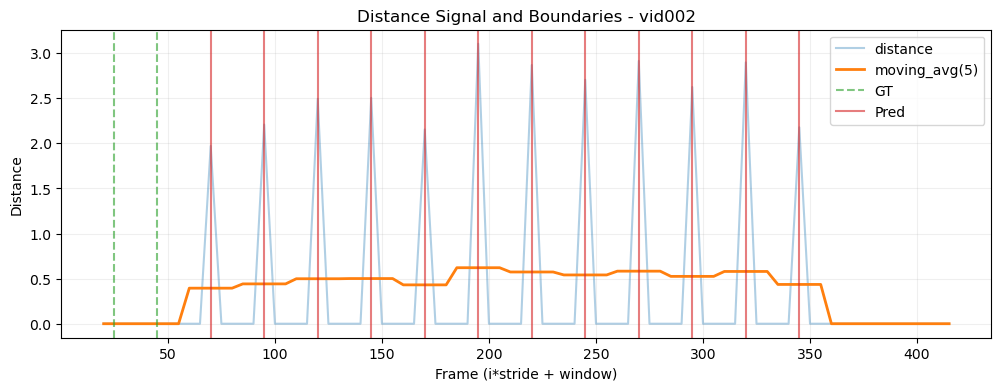

In [3]:
plot_video("vid002", smooth_kernel=5)

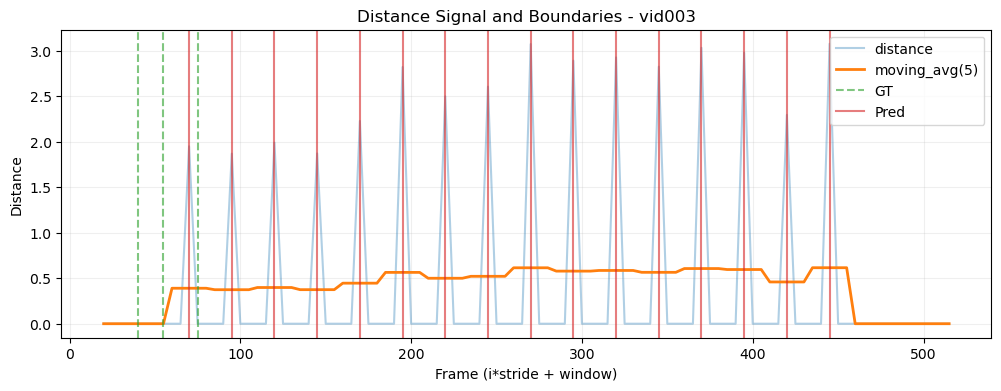

In [4]:
plot_video("vid003", smooth_kernel=5)